In [1]:
# Analyze data
import pandas as pd
import numpy as np
from collections import Counter
import statistics

# Remove warnings
import warnings
warnings.simplefilter("ignore")

# Plot graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier

# Data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import LabelEncoder

# Scoring
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [2]:
data_dir = '../data/'

kish_data = pd.read_csv(data_dir + 'e-coli-data.csv')
moloch_data = pd.read_csv(data_dir + 'molochka.csv')

In [3]:
kish_data.drop(columns=['Compound'], inplace=True)
kish_data['Name'] = 1

moloch_data.drop(columns=['Compound'], inplace=True)
moloch_data['Name'] = 0

# 0 - Milk, 1 - e-coli

In [5]:
kish_data.sample(5)

,0.02 V,0.1 V,0.5 V,1 V,5 V,Name
21606,-1.734930e-06,0.000007,0.000033,0.000072,0.00703,1
49140,-1.580000e-06,-0.000004,-0.000016,-0.000078,-0.00630,1
44454,2.690000e-06,0.000002,0.000004,0.000007,0.00188,1
11720,2.803330e-05,0.000030,0.000057,0.000094,0.00354,1
25547,-6.599720e-07,0.000001,0.000038,0.000106,0.01459,1


In [6]:
moloch_data.rename(columns={'1.0 V':'1 V', '5.0 V': '5 V'}, inplace=True)
data = pd.concat([kish_data, moloch_data], ignore_index=True)

<Axes: xlabel='Name', ylabel='Count'>

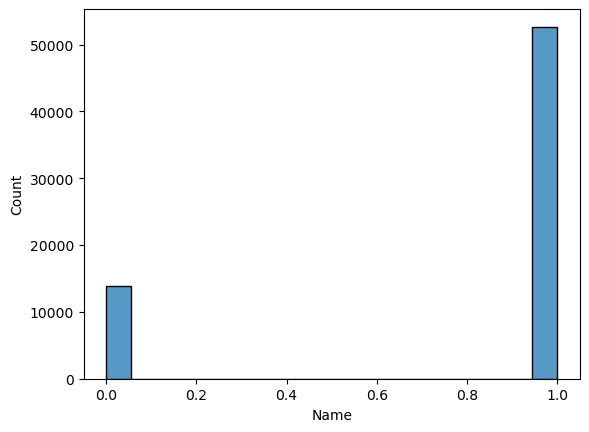

In [7]:
sns.histplot(data["Name"])

In [8]:
X = data.drop(columns=["Name"])
y = data["Name"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

under_sampler = RandomUnderSampler(random_state=1)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print("Class distribution after undersampling:", Counter(y_train))

Class distribution after undersampling: Counter({0: 11157, 1: 11157})


<Axes: xlabel='Name', ylabel='Count'>

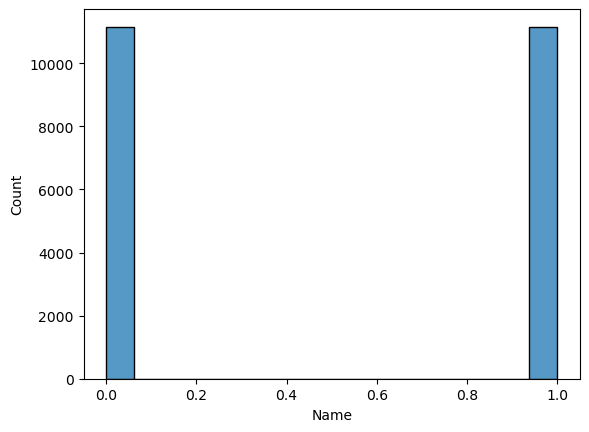

In [9]:
sns.histplot(y_train)

In [10]:
# MinMaxScaled Data

mms = MinMaxScaler()

mms.fit(X_train)
X_mms_train = mms.transform(X_train)
X_mms_test = mms.transform(X_test)

In [11]:
# RobustScaled Data

rs = RobustScaler()

rs.fit(X_train)
X_rs_train = rs.transform(X_train)
X_rs_test = rs.transform(X_test)

In [12]:
# Normalized Data

ner = Normalizer()

ner.fit(X_train) 
X_ner_train = ner.transform(X_train)
X_ner_test = ner.transform(X_test)

In [13]:
def train_model(models, X_train, y_train, X_test, y_test):
    acc  = []
    mod  = []
    prec = []
    rec  = []
    f1   = []

    for i in range(len(models)):
        mod.append(str(models[i]))

        models[i].fit(X_train, y_train)
        y_pred = models[i].predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred, average='macro'))
        rec.append(recall_score(y_test, y_pred, average='macro'))
        f1.append(f1_score(y_test, y_pred, average='macro'))

    data = {'Model'     : mod,
            'Accuracy'  : acc,
            'Precision' : prec,
            'Recall'    : rec,
            'F1-score'  : f1}
    
    return pd.DataFrame(data)

In [14]:
model_list = [RandomForestClassifier(), ExtraTreesClassifier(), SVC(), LogisticRegression()]

In [15]:
train_model(model_list, X_train, y_train, X_test, y_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.969601,0.938249,0.977613,0.956092
1,ExtraTreesClassifier(),0.991293,0.980471,0.993967,0.987029
2,SVC(),0.502965,0.558963,0.586014,0.482699
3,LogisticRegression(),0.519628,0.493851,0.490783,0.458909


In [16]:
train_model(model_list, X_mms_train, y_train, X_mms_test, y_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.982587,0.962892,0.987143,0.974372
1,ExtraTreesClassifier(),0.992344,0.982806,0.994631,0.988574
2,SVC(),0.697891,0.697085,0.797760,0.669704
3,LogisticRegression(),0.580800,0.559631,0.589600,0.530366


In [17]:
train_model(model_list, X_rs_train, y_train, X_rs_test, y_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.983112,0.963599,0.988003,0.975148
1,ExtraTreesClassifier(),0.991744,0.981469,0.994252,0.987690
2,SVC(),0.732192,0.711973,0.818527,0.700022
3,LogisticRegression(),0.601516,0.569812,0.604150,0.547050


In [18]:
train_model(model_list, X_ner_train, y_train, X_ner_test, y_test)

,Model,Accuracy,Precision,Recall,F1-score
0,RandomForestClassifier(),0.949711,0.908338,0.953035,0.928077
1,ExtraTreesClassifier(),0.950161,0.908685,0.954375,0.928805
2,SVC(),0.254822,0.585769,0.524720,0.235483
3,LogisticRegression(),0.570742,0.549860,0.574932,0.519310


In [19]:
scaler = MinMaxScaler()

rfc = RandomForestClassifier()
etc = ExtraTreesClassifier()

X_scaled = scaler.fit_transform(X)


print(cross_val_score(rfc, X_scaled, y, cv=StratifiedKFold(shuffle=True)))
print(cross_val_score(etc, X_scaled, y, cv=StratifiedKFold(shuffle=True)))      

[0.99452075 0.99542145 0.99452075 0.99527098 0.99429515]
[0.99842378 0.99714779 0.99872401 0.99699745 0.99902417]


___

# TabNet

In [15]:
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":10, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                      )

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [16]:
clf.fit(
    X_rs_train, y_train.values,
    eval_set=[(X_rs_train, y_train.values), (X_rs_test, y_test.values)],
    eval_name=['train', 'test'],
    eval_metric=['balanced_accuracy'],
    max_epochs=500, patience=250,
    batch_size=512, virtual_batch_size=512,
    num_workers=0,
    weights=1,
    drop_last=False
)       

epoch 0  | loss: 0.48989 | train_balanced_accuracy: 0.62916 | test_balanced_accuracy: 0.63265 |  0:00:03s
epoch 1  | loss: 0.42651 | train_balanced_accuracy: 0.74227 | test_balanced_accuracy: 0.74263 |  0:00:05s
epoch 2  | loss: 0.3971  | train_balanced_accuracy: 0.76082 | test_balanced_accuracy: 0.76142 |  0:00:07s
epoch 3  | loss: 0.36372 | train_balanced_accuracy: 0.82894 | test_balanced_accuracy: 0.81876 |  0:00:09s
epoch 4  | loss: 0.37628 | train_balanced_accuracy: 0.79748 | test_balanced_accuracy: 0.7952  |  0:00:11s
epoch 5  | loss: 0.35515 | train_balanced_accuracy: 0.79031 | test_balanced_accuracy: 0.78253 |  0:00:13s
epoch 6  | loss: 0.32458 | train_balanced_accuracy: 0.85951 | test_balanced_accuracy: 0.85307 |  0:00:15s
epoch 7  | loss: 0.29691 | train_balanced_accuracy: 0.80304 | test_balanced_accuracy: 0.79903 |  0:00:17s
epoch 8  | loss: 0.29294 | train_balanced_accuracy: 0.84812 | test_balanced_accuracy: 0.84249 |  0:00:19s
epoch 9  | loss: 0.28558 | train_balanced_accu

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


___

# Catboost

In [24]:
clf =  CatBoostClassifier(task_type='GPU',
                          bootstrap_type='Poisson',
                          eval_metric='Accuracy',
                          loss_function='MultiClass',
                          depth=8,
                          od_wait=50,
                          l2_leaf_reg=1,
                          iterations=5000,
                          learning_rate=0.1,
                          verbose=250)

cross_val_score(clf, X, y, cv=StratifiedKFold(shuffle=True))

0:	learn: 0.8476450	total: 22.4s	remaining: 1d 7h 7m 19s
250:	learn: 0.9776694	total: 24.4s	remaining: 7m 41s
500:	learn: 0.9927378	total: 26.3s	remaining: 3m 56s
750:	learn: 0.9974104	total: 28.3s	remaining: 2m 40s
1000:	learn: 0.9991556	total: 30.2s	remaining: 2m
1250:	learn: 0.9996435	total: 32.2s	remaining: 1m 36s
1500:	learn: 0.9998499	total: 34.2s	remaining: 1m 19s
1750:	learn: 0.9999625	total: 36.4s	remaining: 1m 7s
2000:	learn: 1.0000000	total: 38.4s	remaining: 57.5s
2250:	learn: 1.0000000	total: 40.3s	remaining: 49.2s
2500:	learn: 1.0000000	total: 42.2s	remaining: 42.2s
2750:	learn: 1.0000000	total: 44.2s	remaining: 36.1s
3000:	learn: 1.0000000	total: 46.1s	remaining: 30.7s
3250:	learn: 1.0000000	total: 48.1s	remaining: 25.9s
3500:	learn: 1.0000000	total: 50s	remaining: 21.4s
3750:	learn: 1.0000000	total: 52s	remaining: 17.3s
4000:	learn: 1.0000000	total: 54s	remaining: 13.5s
4250:	learn: 1.0000000	total: 56s	remaining: 9.87s
4500:	learn: 1.0000000	total: 57.9s	remaining: 6.42

array([0.99752308, 0.99842378, 0.9976732 , 0.99782315, 0.99737277])

In [25]:
model = ExtraTreesClassifier()

values = cross_val_score(model, X_scaled, y, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.99812355 0.99804849 0.99804849 0.99819847 0.9981234 ]
0.9981084788992508


In [26]:
model = RandomForestClassifier()

values = cross_val_score(model, X_scaled, y, cv=KFold(shuffle=True))

print(values)
print(statistics.mean(values))

[0.99534639 0.9949711  0.99459581 0.99557124 0.99557124]
0.9952111557827982


In [20]:
values = [0.9952111557827982, 0.9981084788992508, 0.9984237887342]      # Recalls

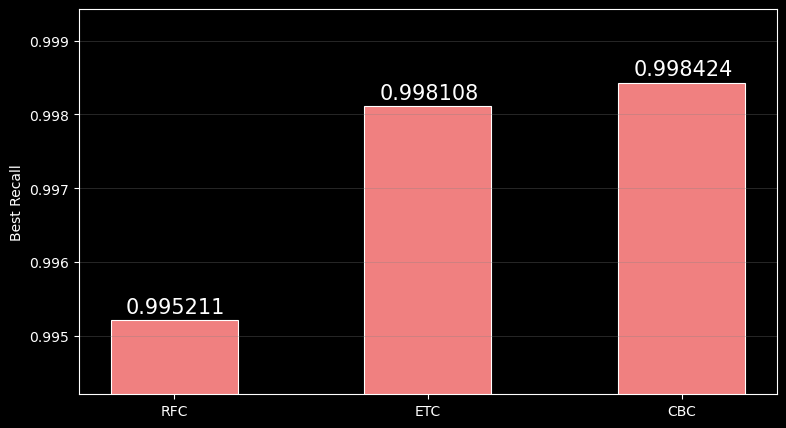

In [21]:
plt.style.use(['dark_background'])
plt.figure(figsize=(9, 5))

plt.bar(range(len(values)), values, color='lightcoral', width=0.5, edgecolor='white', linewidth=0.8)

for i, v in enumerate(values):
    plt.text(i-0.19, v+0.0001, str(round(v, 6)), fontsize=15)

plt.ylabel('Best Recall')
plt.ylim(min(values)-0.001, max(values)+0.001)
plt.xticks([i for i in range(len(values))], ['RFC', 'ETC', 'CBC'])
plt.grid(color='grey', linewidth=0.7, axis='y', alpha=0.3)

plt.show()